## Children Speech Patterns with Age

I wanted to learn more about Natural Language Processing and applying it to speech development in children. This notebook is my first attempt at findings patterns of children's speech at different ages and possibly predicting the age of a child based on speech patterns.

I found transcripts of children speech corpora at childes.talkbank.org. CHILDES transcripts use the CHAT format and are saved as .cha files.

I chose to only look at the children's speech in this study, so the text is made up of only the child's speech (not the investigator or parent's speech).

## Importing Necessary Libraries 

In [21]:
import os
import glob
from PIL import Image
from pprint import pprint
import numpy as np
import pandas as pd
pd.set_option('display.width', 2000)
from datetime import time
import re
from collections import Counter
from nltk import word_tokenize, FreqDist, pos_tag
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA


%matplotlib inline

## Import Transcripts From Local .cha Files

In [2]:
path = '/Users/Jackie/nltk_data/corpora/CHILDES/**/*.cha'
files = glob.iglob(path, recursive = True)

speech_list = []
file_list = []

print('Getting files...\n')
for file in files:
    file_list.append(file)
    with open(file) as f:
        speech_list.append(f.read())

print('Found %d files\n' % len(speech_list))
#print('An example of a transcript:\n', speech_list[30])

Getting files...

Found 3019 files



In [3]:
#print('An example of a transcript:\n', speech_list[30])

## Cleaning Up the Transcripts

In [4]:
# Filter list of speeches to grab only those with age of child recorded (label)
# Grab just the child's utterances from the speeches

child_speech_list = []
speech_labels = []
gender_labels = []

for speech in speech_list:
    label = re.findall(r'\|CHI\|(.*?)\|', speech)
    gender = re.findall(r'\|CHI\|.*?\|(.*?)\|', speech)
    if len(label) != 0 and len(gender) != 0:
        speech_labels.append(str(label))
        child_speech_list.append(re.findall('\*CHI:\t(.*)', speech))
        gender_labels.append(str(gender))
    else:
        speech_labels.append(str(np.NaN))
        child_speech_list.append(str(np.NaN))
        gender_labels.append(str(np.NaN))
    
speech_labels = [re.sub('\[|\]|', '', label) for label in speech_labels] 
speech_labels = [label.replace("'", '') for label in speech_labels]

print('Number of Speeches in Speech List:', len(child_speech_list))
print('Number of Speech Labels:', len(speech_labels))
print('Number of Gender Labels:', len(gender_labels))


# If an age or gender was not recorded, drop the speech and the label

child_speech_list = [x for x in child_speech_list if str(x) != 'nan']
speech_labels = [x for x in speech_labels if str(x) != 'nan']
gender_labels = [x for x in gender_labels if str(x) != 'nan']

print('\nNew Number of Speeches in Speech List:', len(child_speech_list))
print('New Number of Speech Labels:', len(speech_labels))
print('New Number of Gender Labels:', len(gender_labels))

Number of Speeches in Speech List: 3019
Number of Speech Labels: 3019
Number of Gender Labels: 3019

New Number of Speeches in Speech List: 2988
New Number of Speech Labels: 2988
New Number of Gender Labels: 2988


In [5]:
print('An example of a raw speech:\n\n', child_speech_list[30])

# remove the space and period after every utterance
child_speech_list = [[re.sub('\s\.', '', line) for line in speech] 
                     for speech in child_speech_list]

# remove the comments made in square brackets (ie [grunting])
child_speech_list = [[re.sub('\[.*\]', '', line) for line in speech] 
                     for speech in child_speech_list]

# Change "O" to "oh"
child_speech_list = [[re.sub('0', 'oh', line) for line in speech] 
                     for speech in child_speech_list]

# remove symbols within speech (ie .@<[]&+!() )
child_speech_list = [[re.sub(r'[&:@<>().?!+=_-]', '', line) for line in speech] 
                     for speech in child_speech_list]

# remove inaudible words "xxx" and "yyy" from speech
child_speech_list = [[re.sub('xxx|yyy', '', line) for line in speech] 
                     for speech in child_speech_list]

# remove utterances left empty after removing inaudible
child_speech_list = [[re.sub(r'^\s*$', '', line) for line in speech] 
                     for speech in child_speech_list]

# remove 'laughs' because the child was actually laughing, not saying the word
child_speech_list = [[re.sub(r'laughs', '', line) for line in speech]
                     for speech in child_speech_list]

# remove numbers from speeches
child_speech_list = [[re.sub(r'[0-9]', '', line) for line in speech]
                     for speech in child_speech_list]

print('\n\nAn example of a cleaned-up speech:\n\n', child_speech_list[30])

An example of a raw speech:

 ['right here ?', 'ye(a)h .', 'xxx .', 'right here .', '0 .', 'right here ?', 'right here ?', 'oh !', 'yeah !', '0 .', '&-eh !', 'ugh .', 'ugh .', 'right here ?', '&-uh .', '(a)gain .', 'right here .', 'right here .', 'ah !', 'right here ?', '0 .', 'yyy take it all [!] out [!] .', 'yyy .', '(o)kay .', 'okay !', '&-uh and that &-uh now [?] .', 'huh .', 'okay (.) that .', 'here ?', '&-uh yyy heavy .', 'yeah .', 'block !', 'where this block .', 'yyy !', 'yeah .', 'ah !', 'dog .', 'doggie .', 'doggie .', '&-uh doggie .', 'where doggie ?', 'yeah .', 'this go in here .', '0 [=! sighs] .', 'here yyy go .', 'yyy .', 'moink@o .', 'more ball .', 'boink@o !', 'muh_oink@o !', 'boink@o !', 'moick@o !', 'oh in here ?', 'moick@o .', 'moick@o .', '&-uh moink@o .', 'moink@o .', '&-uh .', 'yeah .', 'it went in here .', 'went in here ?', '0 .', '0 .', 'right here ?', 'oh !', '0 .', 'right here .', 'right here ?', 'yyy .', 'I did it .', 'go right here ?']


An example of a cle

## Create the Dataframe and Format 'Age' column (recorded in months)

In [6]:
# Display the age of the child in months

def format_age(label):
    """
    Args:
        label (str or object) - child's age in CHA format (1;11,02)
    Returns:
        age (float) of child in months
    """
    age = 0
    
    years = re.findall('(.*);', label)
    #print(years)
    if len(years) != 0:
        age += float(years[0]) * 12
    else:
        age = np.NaN
    
    months = re.findall(';(.*)\.', label)
    if len(months) != 0:
        age += float(months[0])

    return '{0:g}'.format(float(age))

df = pd.DataFrame()
df['age'] = [format_age(label) for label in speech_labels]
df['speech'] = [x for x in child_speech_list]
df['gender'] = [x for x in gender_labels]

print(df.head())
print(df.shape)

  age                                             speech      gender
0  20  [, yeah, , yeah,  woof, oh, hat, yeah , , hey ...  ['female']
1  20  [oh, , that baby , oh, , , uh , oh, oh, oh, oh...  ['female']
2  20  [ball , ball, ball oh , ball , ball , oh, , uh...    ['male']
3  20  [oh, table, oh, , oh, oh, oh, oh, oh, oh, oh ,...    ['male']
4  20  [dog , dog , one , three , gramma , two , gram...    ['male']
(2988, 3)


In [7]:
def binary_gender(row):
     
    listed = row['gender']
    
    gender = re.sub(r'[\'\[\]]', '', listed)
    if gender == 'male':
        df.loc[index, 'male'] = '{0:g}'.format(1)
    else:
        df.loc[index, 'male'] = '{0:g}'.format(0)
    if gender == 'female':
        df.loc[index, 'female'] = '{0:g}'.format(1)
    else:
        df.loc[index, 'female'] = '{0:g}'.format(0)

for index, row in df.iterrows():
    binary_gender(row)

df = df.drop(['gender'], axis = 1)

## Clean up the dataframe and define our age limits
Drop speeches that do not have an age recorded and drop speeches without any text.
Drop any speeches outside the range of 2 and 6 years old.

In [8]:
df = df[df['age'] != 'nan']
df = df[df.astype(str)['speech'] != '[]']
df.age = df.age.astype(int)
df = df[(df.age <= 72) & (df.age >= 18)]

In [9]:
df.shape

(2871, 4)

## Number of Utterances within a Speech

The number of utterances and number of words per speech doesn't tell us much about a child's speech patterns necessarily because it's dependent upon the duration of the recorded session, the amount of prompting the child received, and the speed at which the child talks.

This was calculated and plotted just to show the information about the dataset

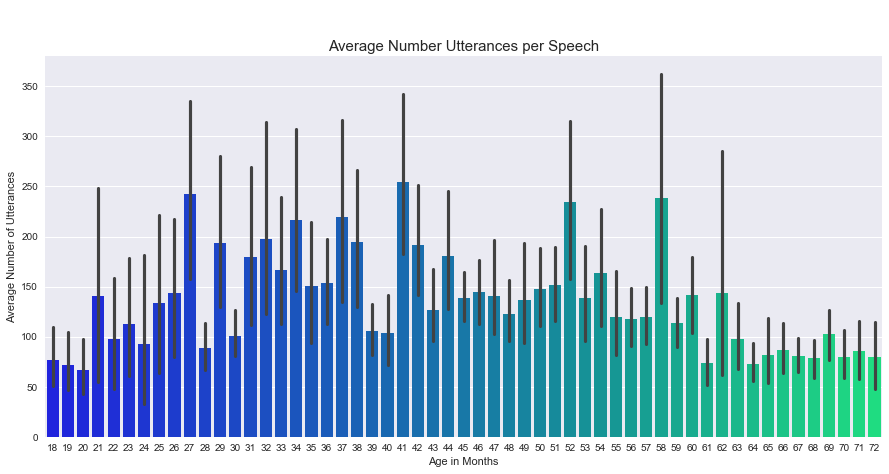

In [10]:
df['utterance_count'] = [len(speech) for speech in df.speech]

fig = plt.figure(figsize=(15, 7))
_ = sns.barplot(x = 'age', y = 'utterance_count', data = df, palette = 'winter')
_ = plt.title('\n\nAverage Number Utterances per Speech', size = 15)
_ = plt.ylabel('Average Number of Utterances')
_ = plt.xlabel('Age in Months')
plt.show()

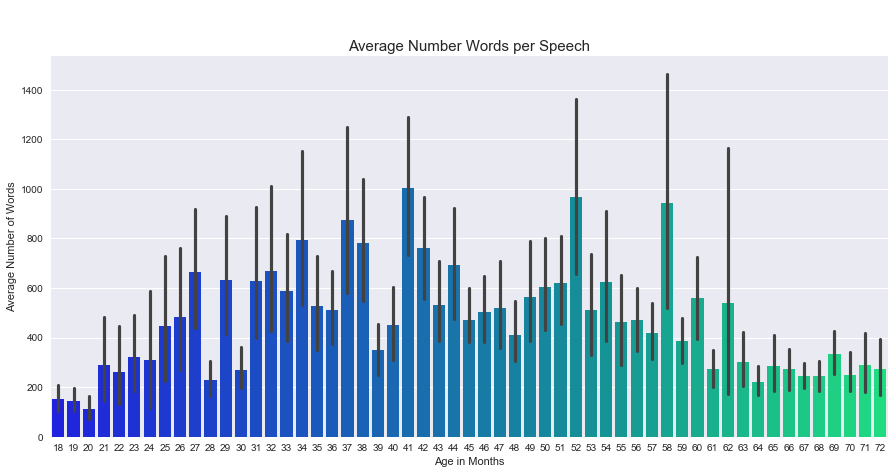

In [11]:
def word_count(speech):
    """
    Args:
        speech (str or list object) - speech corpus
    Returns:
        word count per speech (float)
    """
    
    word_count = []
    
    for line in speech:
        count = len(line.split())
        word_count.append(count)

    return sum(word_count)

df['word_count'] = [word_count(speech) for speech in df.speech]
df = df[df['word_count'] >= 10]

fig = plt.figure(figsize=(15, 7))
_ = sns.barplot(x = 'age', y = 'word_count', data = df, palette = 'winter')
_ = plt.title('\n\nAverage Number Words per Speech', size = 15)
_ = plt.ylabel('Average Number of Words')
_ = plt.xlabel('Age in Months')
plt.show()

## Average Number of Words Per Utterance

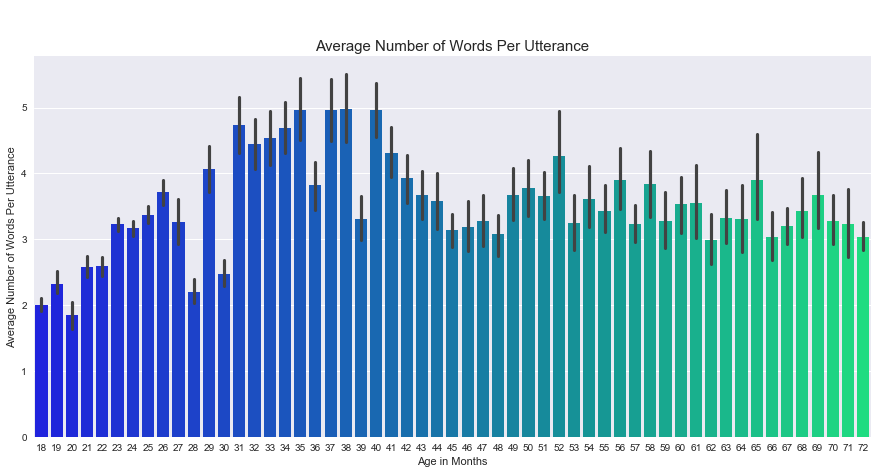

In [12]:
df['avg_word/utterance'] = df['word_count'] / df['utterance_count']


fig = plt.figure(figsize=(15, 7))
_ = sns.barplot(x = 'age', y = 'avg_word/utterance', data = df, palette = 'winter')
_ = plt.title('\n\nAverage Number of Words Per Utterance', size = 15)
_ = plt.xlabel('Age in Months')
_ = plt.ylabel('Average Number of Words Per Utterance')
plt.show()

In [29]:
df

,age,speech,male,female,utterance_count,word_count,avg_word/utterance
0,20,"[, yeah, , yeah, woof, oh, hat, yeah , , hey ...",0,1,74,59,0.797297
1,20,"[oh, , that baby , oh, , , uh , oh, oh, oh, oh...",0,1,49,44,0.897959
2,20,"[ball , ball, ball oh , ball , ball , oh, , uh...",1,0,86,94,1.093023
3,20,"[oh, table, oh, , oh, oh, oh, oh, oh, oh, oh ,...",1,0,24,23,0.958333
4,20,"[dog , dog , one , three , gramma , two , gram...",1,0,57,53,0.929825
5,20,"[byebye, oh, oh, oh, oh, oh, oh, oh, oh, oh, o...",1,0,60,65,1.083333
6,22,"[oh, oh, Mommy, Mommy, good Mommy , no Mommy...",0,1,46,31,0.673913
7,20,"[uh , oh, oh, oh, oh, oh, oh, oh, oh, uh , oh,...",1,0,85,89,1.047059
8,20,"[my chicken, my chicken , my chicken, um, oh, ...",0,1,37,41,1.108108
9,20,"[oh, oh, oh, oh, no , oh, oh, oh, oh, oh, oh, ...",0,1,49,45,0.918367


In [30]:
fig = plt.figure(figsize=(15, 7))

male_df = df[df['male'] == 1]
female_df = df[df['female'] == 1]

_ = sns.barplot(x = 'age', 
                y = 'avg_word/utterance', 
                data = male_df, 
                color = 'Blue', 
                alpha = 0.4, 
                label = 'Males'
               )
_ = sns.barplot(x = 'age', 
                y = 'avg_word/utterance', 
                data = female_df, 
                color = 'Green', 
                alpha = 0.4, 
                label = 'Females'
               )

_ = plt.title('\n\nAverage Number of Words Per Utterance Males vs Females', size = 15)
_ = plt.xlabel('Age in Months')
_ = plt.ylabel('Average Number of Words Per Utterance')
_ = plt.legend(fontsize = 'x-large')
plt.show()

ValueError: min() arg is an empty sequence

## Average Length of Words in Speech

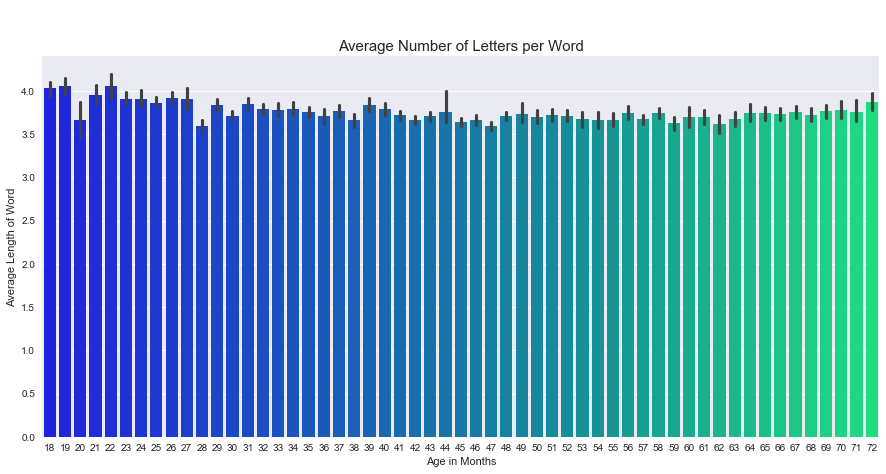

In [31]:
def avg_letters_word(speech):
    """
    Args:
        speech (str or list object) - speech corpus
    Returns:
        average word length speech(float)
    """
    
    letter_count = []
    
    for line in speech:
        words = line.split()
        for word in words:
            letters = list(word)
            num_letters = len(letters)
            letter_count.append(num_letters)
    
    return np.mean(letter_count)

df['avg_letters/word'] = [avg_letters_word(speech) for speech in df.speech]

fig = plt.figure(figsize=(15, 7))
_ = sns.barplot(x = 'age', y = 'avg_letters/word', data = df, palette = 'winter')
_ = plt.title('\n\nAverage Number of Letters per Word', size = 15)
_ = plt.ylabel('Average Length of Word')
_ = plt.xlabel('Age in Months')
plt.show()

## Words Used Most Frequently

In [32]:
def top_10(speech):
    """
    Args:
        speech (str or list object) - speech corpus
    Returns:
        list of top 10 most frequent words (list)
    """
    
    words_list = []
    for line in speech:
        words = line.split()
        for word in words:
            words_list.append(word)
        
    freq_dist = FreqDist(w.lower() for w in words_list)
    most_freq = []
    most_freq.append(freq_dist.keys())

    return most_freq


df['top_10_words'] = [top_10(speech) for speech in df.speech]

df.loc[:10, ['age','top_10_words']]

,age,top_10_words
0,20,"[(yeah, woof, oh, hat, hey, ahti, ow, ah, no, ..."
1,20,"[(oh, that, baby, uh, chick, car, mapapapo, no..."
2,20,"[(ball, oh, uh, uhuh, where, right, in, there,..."
3,20,"[(oh, table, no, mommy, cooker, sandy)]"
4,20,"[(dog, one, three, gramma, two, grammas, chair..."
5,20,"[(byebye, oh, ball, ol, eh, huh, what's, that,..."
6,22,"[(oh, mommy, good, no, uhoh, alright, gramma, ..."
7,20,"[(uh, oh, um, more, where, huh, here, okay, bo..."
8,20,"[(my, chicken, um, oh, ball, two)]"
9,20,"[(oh, no, mommy, ball)]"


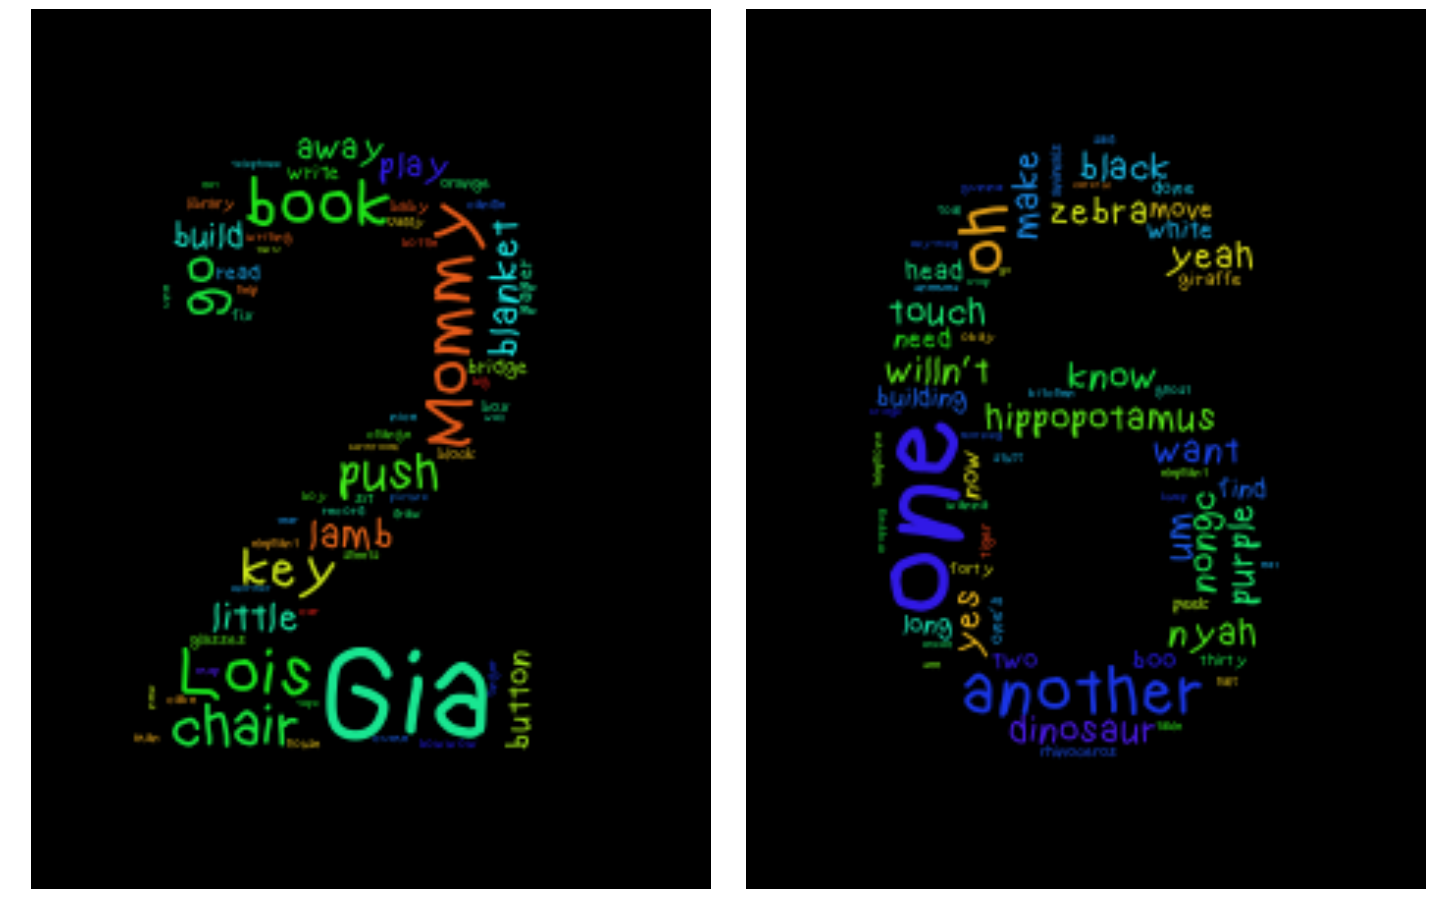

In [ ]:
# Generate word clouds for two different ages

num2_mask = np.array(Image.open('num2.jpg'))
num6_mask = np.array(Image.open('num6.jpg'))


wordcloud2 = WordCloud(
                      font_path = '/Users/Jackie/Desktop/Kindergarten.ttf',
                      background_color = 'Black',
                      mask = num2_mask,
                      regexp = None).generate('+'.join(df.speech[162]))

wordcloud6 = WordCloud(
                      font_path = '/Users/Jackie/Desktop/Kindergarten.ttf',
                      background_color = 'Black',
                      mask = num6_mask,
                      regexp = None).generate('+'.join(df.speech[2275]))


fig = plt.figure(figsize=(20, 40))
ax1 = fig.add_subplot(1,2,1)
_ = ax1.imshow(wordcloud2, interpolation = 'bilinear')
_ = ax1.axis('off')
ax2 = fig.add_subplot(1,2,2)
_ = ax2.imshow(wordcloud6, interpolation = 'bilinear')
_ = ax2.axis('off')
_ = plt.tight_layout()
plt.show()

## Parts of Speech

In [ ]:
# Use NLTK pos_tag to tag parts of speech

def pos_count(row):
    """
    Args:
        speech (str or list object) - speech corpus
    Returns:
        A total percentage for each part of speech used (ie nouns, verbs) (float)
    """
    speech = row['speech']
    
    words_list = []
    for line in speech:
        words = line.split()
        for word in words:
            words_list.append(word)
    
    pos_list = []
    tagged = pos_tag(words_list)
    #print(tagged)
    
    # Initalize POS Count
    nouns = 0
    verbs = 0
    tenses = 0
    adverbs = 0
    adjectives = 0
    prepositions = 0
    pronouns = 0
    possessives = 0
    interjections = 0
    unknowns = 0
    other = 0
    total = 0
    
    # Count POS
    for word, tag in tagged:
        total += 1
        if tag in ['NN', 'NNS', 'NNP', 'NNPS']:
            nouns += 1
        elif tag in ['VB', 'VBP']: 
            verbs += 1    
        elif tag in ['VBD', 'VBG', 'VBN', 'VBZ']:
            tenses += 1
        elif tag in ['RB', 'RBR', 'RBS', 'RP', 'WRB']:
            adverbs += 1
        elif tag in ['JJ', 'JJR', 'JJS']:
            adjectives += 1
        elif tag in ['IN']:
            prepositions += 1
        elif tag in ['PRP', 'PRP$', 'WP', 'WP$']:
            pronouns += 1
        elif tag in ['POS']:
            possessives += 1
        elif tag in ['UH']:
            interjections += 1
        elif tag in ['FW']:
            unknowns += 1
        else:
            other += 1
    
    # Record POS count as a percentage in dataframe
    if total != 0:
        # basic pos
        df.loc[index, '%nouns'] = nouns / total * 100
        df.loc[index, '%verbs'] = verbs / total * 100
        df.loc[index, '%tenses'] = tenses / total * 100
        df.loc[index, '%adverbs'] = adverbs / total * 100
        df.loc[index, '%adjectives'] = adjectives / total * 100
        df.loc[index, '%prepositions'] = prepositions / total * 100
        df.loc[index, '%pronouns'] = pronouns / total * 100
        df.loc[index, '%possessives'] = possessives / total * 100 
        df.loc[index, '%interjections'] = interjections / total * 100 
        df.loc[index, '%unknowns'] = unknowns / total * 100
        df.loc[index, '%other'] = other / total * 100      
    else:
        df.loc[index, ['%nouns', '%verbs', '%tenses', '%adverbs', 
                       '%adjectives', '%prepositions','%pronouns', 
                       '%possessives', '%interjections', '%other']] = 0
        
for index, row in df.iterrows():
    pos_count(row)

In [ ]:
# Made a separate dataframe for the parts of speech to make plotting easier

pos_df = df[['age', '%nouns', '%verbs', '%tenses', '%adverbs', '%adjectives',
             '%prepositions', '%pronouns', '%possessives', '%interjections',
             '%unknowns', '%other']]
pos_df = pos_df.set_index('age')
pos_df.columns = ['Nouns', 'Verbs', 'Tenses', 'Adverbs', 'Adjectives', 'Prepositions', 
                  'Pronouns', 'Possessives', 'Interjections', 'Unknowns', 'Other']
pos_df = pos_df.sort_index(ascending = True)
pos_df = pos_df.groupby(pos_df.index).mean()
#print(pos_df)

In [ ]:
# Plot parts of speech versus age

ax = pos_df.plot.bar(
                    figsize = [15, 8], 
                    colormap = 'GnBu', 
                    stacked = True, 
                    width = 0.9,
                    title = 'Percent Parts of Speech Used at Each Age')

_ = ax.set_xlabel('Age in Months')
_ = ax.set_ylabel('Percent Usage')

In [ ]:
df.dtypes
df.male = df.male.astype(int)
df.female = df.female.astype(int)
df.dtypes

## Model

In [461]:
# Split the dataframe into X and y
y = df[['age']]
X = df[['avg_word/utterance', 'avg_letters/word', '%nouns', '%verbs', '%tenses', 
        '%adverbs', '%adjectives','%prepositions', '%pronouns', 
        '%possessives', '%interjections', '%unknowns', '%other', 'male', 'female']]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 6)

## PCA

In [473]:
pca = PCA(n_components = 3)
pca.fit_transform(X_train)
pca.transform(X_test)

array([[ -7.16251018,   2.20625164,  -6.37269674],
       [-12.62446802,   2.4671724 ,   0.41070046],
       [-10.27461729,   3.33219251,  -1.08044764],
       ..., 
       [ 22.35689566,   2.35765513,   1.40999185],
       [ -3.75643658,   5.22967322,   0.36967491],
       [ 26.32421183,   7.01657345,   7.4337924 ]])

std_sc = StandardScaler()
sc_X_train = std_sc.fit_transform(X_train)
sc_X_test = std_sc.transform(X_test)

In [474]:
reg = linear_model.Lasso()
rf.fit(X_train, y_train.values.ravel())
y_pred = rf.predict(X_test)

print('mae', mean_absolute_error(y_test, y_pred))
print('mse', mean_squared_error(y_test, y_pred))
print('r2', r2_score(y_test, y_pred))

mae 8.5255648038
mse 125.267895363
r2 0.426059962208


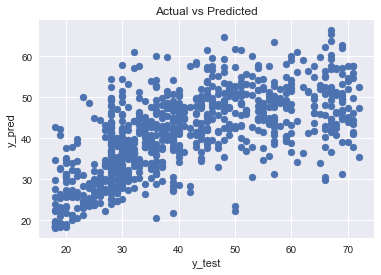

In [475]:
results = pd.DataFrame()   # dataframe for predictions vs actual y-values
results['predictions'] = y_pred
results['actual'] = y_test['age'].values

results[:10]

# plotting actual vs predicted
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')
plt.title('Actual vs Predicted')
plt.show()